# Data Mart configuration and usage with `ibm-ai-openscale` python package

<img src="https://console-lon02-black.cdn.stage1.s-bluemix.net/catalog/proxy-image/service-icon?url=https%3A%2F%2Faiopenscale-broker-ys1prod.stage1.mybluemix.net%2Fpublic%2Ffeatured.png" align="left" alt="banner" width="65">

This notebook shows hot to create a data mart for Watson Machine Learning deployments. It includes steps for performance, bias and quality monitor configurations.

Contents
- [1. Setup](#setup)
- [2. Binding machine learning engine](#binding)
- [3. Subscriptions](#subscription)
- [4. Score models](#scoring)
- [5. Data Mart](#datamart)
- [6. Visualization](#visualization)

<a id="setup"></a>
## 1. Setup

### 1.1 Installation and authentication

In [ ]:
!pip install --upgrade ibm-ai-openscale

In [ ]:
!pip install --upgrade watson-machine-learning-client

### ACTION: Restart kernel to make sure installed versions are used.

Import and initiate.

In [1]:
from ibm_ai_openscale import APIClient
from ibm_ai_openscale.engines import *

### ACTION: Get `data_mart_id` (GUID) and `apikey`

How to get api key using bluemix console:
```
bx login --sso
bx iam api-key-create 'my_key'
```

How to get DATA_MART_ID (this is AI OpenScale instance GUID)
```
bx resource service-instance ‘instance_name’
```


In [2]:
aios_credentials = {
  "data_mart_id": "*****",
  "apikey": "*****", 
  "url": "https://api.aiopenscale.cloud.ibm.com"
}

In [3]:
# The code was removed by Watson Studio for sharing.

### ACTION: Add your Watson Machine Learning credentials here

In [4]:
wml_credentials =  {
  "apikey": "***",
  "iam_apikey_description": "Auto generated apikey during resource-key operation for Instance - crn:v1:bluemix:public:pm-20:us-south:a/181ed6cc388f47bd9d862fe066f9cfce:c419e24a-c4eb-41b4-a2e1-ce4f0d298428::",
  "iam_apikey_name": "auto-generated-apikey-33f864a1-9958-4a32-b9ab-6fd962f98522",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/181ed6cc388f47bd9d862fe066f9cfce::serviceid:ServiceId-e847629a-195e-455d-a949-957263b867ab",
  "instance_id": "***",
  "password": "***",
  "url": "https://us-south.ml.cloud.ibm.com",
  "username": "*****"
}

In [5]:
# The code was removed by Watson Studio for sharing.

### ACTION: Add your PostgreSQL credentials here

In [6]:
postgres_credentials = {
    "db_type": "postgresql",
    "uri_cli_1": "xxx",
    "maps": [],
    "instance_administration_api": {
        "instance_id": "xxx",
        "root": "xxx",
        "deployment_id": "xxx"
    },
    "name": "xxx",
    "uri_cli": "xxx",
    "uri_direct_1": "xxx",
    "ca_certificate_base64": "xxx",
    "deployment_id": "xxx",
    "uri": "xxx"
}

In [7]:
# The code was removed by Watson Studio for sharing.

In [8]:
client = APIClient(aios_credentials)

In [9]:
client.version

'1.0.1'

Put your schema name here.

In [18]:
schemaName = 'data_mart'

You can use the code below to create the schema. If the schema already exists skipp this cell.

In [19]:
import psycopg2

hostname = postgres_credentials['uri'].split('@')[1].split(':')[0]
port = postgres_credentials['uri'].split('@')[1].split(':')[1].split('/')[0]
user = postgres_credentials['uri'].split('@')[0].split('//')[1].split(':')[0]
password = postgres_credentials['uri'].split('@')[0].split('//')[1].split(':')[1]
dbname = 'compose'

conn_string = "host=" + hostname + " port=" + port + " dbname=" + dbname + " user=" + user + " password=" + password
conn = psycopg2.connect(conn_string)
conn.autocommit = True
cursor = conn.cursor()
try:
    query = "drop schema " + schemaName + " cascade"
    cursor.execute(query)
except:
    pass
finally:    
    try:
        query = "create schema " + schemaName
        cursor.execute(query)
    finally:    
        conn.close()

### 1.2 DataMart setup

In [20]:
client.data_mart.setup(postgres_credentials=postgres_credentials, schema=schemaName)

In [10]:
data_mart_details = client.data_mart.get_details()

Data Mart with instance id name has been created.

<a id="binding"></a>

## 2. Bind machine learning engines

### 2.1 Bind Watson Machine Learning 

You can bind you Watson Machine Learning instance to previously created data mart.

In [23]:
binding_uid = client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance(wml_credentials))

In [11]:
bindings_details = client.data_mart.bindings.get_details()

In [12]:
client.data_mart.bindings.list()

e30fe554-6e3e-4e0e-af06-90f93686f358,WML instance,watson_machine_learning,2018-09-20T08:21:56.421Z


### 2.2 Check available assets from binded services

#### List available assets

In [26]:
client.data_mart.bindings.list_assets()

e660f8ea-fb82-4f3e-9475-9817612abc2b,drug-selection,2018-09-20T08:13:57.668Z,model,mllib-2.1,e30fe554-6e3e-4e0e-af06-90f93686f358,-
b61e1c6a-9f24-4011-8f63-bc9bc115de17,product-line-prediction,2018-09-20T08:12:15.741Z,model,mllib-2.1,e30fe554-6e3e-4e0e-af06-90f93686f358,-


#### Get metadata of available assets

In [27]:
assets_details = client.data_mart.bindings.get_asset_details()

In [28]:
source_assets_uids = []

for x in client.data_mart.bindings.get_asset_details():
    source_assets_uids.append(x['source_uid'])

In [29]:
print(str(source_assets_uids))

['b61e1c6a-9f24-4011-8f63-bc9bc115de17', 'e660f8ea-fb82-4f3e-9475-9817612abc2b']


<a id="subscriptions"></a>
## 3. Subscriptions

### 3.1 Add subscriptions

In [30]:
for uid in source_assets_uids:
    sub = client.data_mart.subscriptions.add(WatsonMachineLearningAsset(uid))
    print("Adding subscription for: " + str(uid))

Adding subscription for: b61e1c6a-9f24-4011-8f63-bc9bc115de17
Adding subscription for: e660f8ea-fb82-4f3e-9475-9817612abc2b


#### Get subscriptions list

In [31]:
subscriptions_uids = client.data_mart.subscriptions.get_uids()
print(subscriptions_uids)

['b61e1c6a-9f24-4011-8f63-bc9bc115de17', 'e660f8ea-fb82-4f3e-9475-9817612abc2b']


#### List subscriptions

In [32]:
client.data_mart.subscriptions.list()

e660f8ea-fb82-4f3e-9475-9817612abc2b,drug-selection,model,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,2018-09-20T08:22:50.786Z
b61e1c6a-9f24-4011-8f63-bc9bc115de17,product-line-prediction,model,e30fe554-6e3e-4e0e-af06-90f93686f358,b61e1c6a-9f24-4011-8f63-bc9bc115de17,2018-09-20T08:22:48.448Z


### 3.2 Enable payload logging and performance monitor for both subscribed assets

In [33]:
for uid in subscriptions_uids:
    subscription = client.data_mart.subscriptions.get(uid)
    subscription.payload_logging.enable()
    subscription.performance_monitoring.enable()

#### Get details of enabled payload logging

In [34]:
payload_logging_details = subscription.payload_logging.get_details()

#### Print schema of payload_logging table

In [35]:
subscription.payload_logging.print_table_schema()

scoring_id,text,-,-,-,N
scoring_timestamp,timestamp,8,-,-,N
deployment_id,text,-,-,-,N
asset_revision,text,-,-,-,N
AGE,int4,4,-,-,N
SEX,text,-,-,-,N
BP,text,-,-,-,N
CHOLESTEROL,text,-,-,-,N
NA,numeric,21,21,2,N
K,numeric,21,21,2,N
prediction,float8,8,-,-,N


### 3.3 Enable Quality (Accuracy) monitor for best heart drug asset

#### Quality monitoring

Get the subscription ID for heart-drug model

In [13]:
subscriptions_details = client.data_mart.subscriptions.get_details()
heart_drug_subscription = None

for s in subscriptions_details['subscriptions']:
    if s['entity']['asset']['name'] == 'drug-selection':
        heart_drug_subscription = s['metadata']['guid']


In [14]:
subscription = client.data_mart.subscriptions.get(heart_drug_subscription)

### ACTION: Put your Spark Service credentials here

In [39]:
spark_credentials = {
                  "tenant_id": "****",
                  "tenant_id_full": "915544ce-9411-437e-8ad5-a45c0b14cebb_01b7600f-62c7-4f5a-974b-9fffe65d1ab9",
                  "cluster_master_url": "https://spark.bluemix.net",
                  "tenant_secret": "***",
                  "instance_id": "****",
                  "plan": "ibm.SparkService.PayGoPersonal"
}

In [40]:
# The code was removed by Watson Studio for sharing.

#### Enable Accuracy monitor for selected subscription

In [41]:
subscription.quality_monitoring.enable(evaluation_method='multiclass', threshold=0.8, min_records=5, spark_credentials=spark_credentials)

#### Send some feedback records to feedback store. 

Feedback records are used to evaluate our model.

In [42]:
subscription.feedback_logging.store(
            [
                [20.0, 'M', 'HIGH', 'HIGH', 0.715337, 0.074773, 'drugB'],
                [38.0, 'F', 'HIGH', 'NORMAL', 0.868924, 0.061023, 'drugB'],
                [68.0, 'F', 'HIGH', 'NORMAL', 0.77541, 0.0761, 'drugB'],
                [65.0, 'M', 'HIGH', 'NORMAL', 0.635551, 0.056043, 'drugB'],
                [30.0, 'F', 'HIGH', 'HIGH', 0.800607, 0.060181, 'drugB'],
                [70.0, 'M', 'HIGH', 'HIGH', 0.658606, 0.047153, 'drugB'],
                [60.0, 'M', 'HIGH', 'HIGH', 0.805651, 0.057821, 'drugB'],
                [59.0, 'M', 'HIGH', 'HIGH', 0.816356, 0.058583, 'drugB'],
                [60.0, 'F', 'HIGH', 'HIGH', 0.800607, 0.060181, 'drugB'],
                [70.0, 'M', 'HIGH', 'HIGH', 0.658606, 0.047153, 'drugB'],
                [60.0, 'M', 'HIGH', 'HIGH', 0.805651, 0.057821, 'drugB'],
                [59.0, 'M', 'HIGH', 'HIGH', 0.816356, 0.058583, 'drugB']
            ],
            fields=['AGE', 'SEX', 'BP', 'CHOLESTEROL', 'NA', 'K', 'DRUG']
        )

<a id="scoring"></a>
## 4. Score models
Working with `watson-machine-learning-client`.

#### Get the initialized `watson-machine-learning` client

In [29]:
wml_client = client.data_mart.bindings.get_native_engine_client(binding_uid=binding_uid)

`watson-machine-learning-client` documentation can be found [here](wml-api-pyclient.mybluemix.net).

Let's list our deployments.

In [30]:
wml_client.deployments.list()

------------------------------------  --------------------------------  ------  --------------  ------------------------  ---------  -------------
GUID                                  NAME                              TYPE    STATE           CREATED                   FRAMEWORK  ARTIFACT TYPE
c71edbca-727c-4e7f-9cd7-99929c5b63bf  CARS4U - Action Model Deployment  online  DEPLOY_SUCCESS  2018-09-20T09:45:22.524Z  mllib-2.1  model
10e2f722-b2b2-4ece-89d4-b691c5ad0d04  drug-selection deployment         online  UPDATE_SUCCESS  2018-09-20T08:14:17.933Z  mllib-2.1  model
a65b7a1c-3563-4748-a05d-9fbddb2f1c0c  product line deployment           online  DEPLOY_SUCCESS  2018-09-20T08:12:33.616Z  mllib-2.1  model
------------------------------------  --------------------------------  ------  --------------  ------------------------  ---------  -------------


Let's extract scoring_ednpoints for both deployments.

In [31]:
heart_scoring_endpoint = None
product_scoring_endpoint = None

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment['entity']['deployable_asset']['name'] == 'drug-selection':
      heart_scoring_endpoint = deployment['entity']['scoring_url']
    elif deployment['entity']['deployable_asset']['name'] == 'product-line-prediction':
      product_scoring_endpoint = deployment['entity']['scoring_url']

### 4.1 Score the best-heart drug model

In [103]:
payload_scoring = {"fields": ["AGE", "SEX", "BP", "CHOLESTEROL","NA","K"],
                           "values": [[20.0, "F", "HIGH", "HIGH", 0.71, 0.07], [55.0, "M", "LOW", "HIGH", 0.71, 0.07]]}

for i in range(1,100):
    scores = wml_client.deployments.score(heart_scoring_endpoint, payload_scoring)

print(str(scores))


{'values': [[20, 'F', 'HIGH', 'HIGH', 0.71, 0.07, 'drugY', 0.0, 1.0, 0.0, 0.0, [20.0, 1.0, 0.0, 0.0, 0.71, 0.07], [0.0, 0.0, 32.0, 0.0, 1.0], [0.0, 0.0, 0.9696969696969697, 0.0, 0.030303030303030304], 2.0, 'drugA'], [55, 'M', 'LOW', 'HIGH', 0.71, 0.07, 'drugY', 0.0, 0.0, 2.0, 0.0, [55.0, 0.0, 2.0, 0.0, 0.71, 0.07], [0.0, 0.0, 0.0, 16.0, 0.0], [0.0, 0.0, 0.0, 1.0, 0.0], 3.0, 'drugC']], 'fields': ['AGE', 'SEX', 'BP', 'CHOLESTEROL', 'NA', 'K', 'DRUG', 'label', 'SEX_IX', 'BP_IX', 'CHOL_IX', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel']}


### 4.2 Score the product-line model

In [38]:
payload_scoring = {"fields": ["GENDER", "AGE", "MARITAL_STATUS", "PROFESSION"],
                           "values": [["M", 23, "Single", "Student"], ["M", 55, "Single", "Executive"], ["F", 23, "Single", "Student"], ["F", 55, "Single", "Executive"]]}

for i in range(1,100):
    scores = wml_client.deployments.score(product_scoring_endpoint, payload_scoring)
    
print(str(scores))

{'values': [['M', 23, 'Single', 'Student', 'Camping Equipment', 0.0, 6.0, 0.0, 1.0, [0.0, 23.0, 1.0, 6.0], [5.258712981131878, 6.723421733525897, 6.0132018750333724, 0.218060296213069, 1.7866031140957863], [0.26293564905659383, 0.3361710866762948, 0.3006600937516686, 0.010903014810653448, 0.0893301557047893], 1.0, 'Personal Accessories'], ['M', 55, 'Single', 'Executive', 'Camping Equipment', 0.0, 3.0, 0.0, 1.0, [0.0, 55.0, 1.0, 3.0], [3.6000096318286547, 4.060237825988732, 3.8628119611335734, 8.339956386992652, 0.13698419405638748], [0.18000048159143273, 0.20301189129943661, 0.19314059805667866, 0.4169978193496326, 0.006849209702819374], 3.0, 'Golf Equipment'], ['F', 23, 'Single', 'Student', 'Camping Equipment', 0.0, 6.0, 1.0, 1.0, [1.0, 23.0, 1.0, 6.0], [4.858129351530234, 10.093510657380714, 4.395102310181971, 0.19561889262018098, 0.45763878828689825], [0.24290646757651171, 0.5046755328690357, 0.21975511550909857, 0.009780944631009049, 0.022881939414344913], 1.0, 'Personal Accessorie

<a id="datamart"></a>
## 5. Data mart

### 5.1 Accessing tables data via subscription
- `show_table`
- `describe_table`
- `get_table_content(format='pandas')`

#### Preview table content

In [15]:
subscription.payload_logging.show_table()

4bc11a9fff1b486d2a70043d558da0fe-1,2018-09-20 08:47:23.799000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,20,F,HIGH,HIGH,0.71,0.07,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY
4bc11a9fff1b486d2a70043d558da0fe-2,2018-09-20 08:47:23.799000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,55,M,LOW,HIGH,0.71,0.07,3.0,drugC,"[0.0, 0.0, 0.0, 1.0, 0.0]",drugY
77089e45eedb88f85a9637ee8ab6c145-1,2018-09-20 08:47:23.812000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,20,F,HIGH,HIGH,0.71,0.07,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY
77089e45eedb88f85a9637ee8ab6c145-2,2018-09-20 08:47:23.812000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,55,M,LOW,HIGH,0.71,0.07,3.0,drugC,"[0.0, 0.0, 0.0, 1.0, 0.0]",drugY
7897bc8861fae2d6c13f595b5a6a7e80-1,2018-09-20 08:47:23.878000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,20,F,HIGH,HIGH,0.71,0.07,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY
7897bc8861fae2d6c13f595b5a6a7e80-2,2018-09-20 08:47:23.878000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,55,M,LOW,HIGH,0.71,0.07,3.0,drugC,"[0.0, 0.0, 0.0, 1.0, 0.0]",drugY
fa39458ef3127f7f596cfb23473eb1ce-1,2018-09-20 08:47:23.942000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,20,F,HIGH,HIGH,0.71,0.07,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY
fa39458ef3127f7f596cfb23473eb1ce-2,2018-09-20 08:47:23.942000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,55,M,LOW,HIGH,0.71,0.07,3.0,drugC,"[0.0, 0.0, 0.0, 1.0, 0.0]",drugY
f9024821356b72d13c5c26564c3f837e-1,2018-09-20 08:47:23.763000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,20,F,HIGH,HIGH,0.71,0.07,2.0,drugA,"[0.0, 0.0, 1.0, 0.0, 0.0]",drugY
f9024821356b72d13c5c26564c3f837e-2,2018-09-20 08:47:23.763000,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,eeaa586e-19c8-45c5-9ef5-1847d09f3f53,55,M,LOW,HIGH,0.71,0.07,3.0,drugC,"[0.0, 0.0, 0.0, 1.0, 0.0]",drugY


Note: First 10 records were displayed.


In [16]:
subscription.performance_monitoring.show_table()

2018-09-20 08:47:23.838000,24.0,48,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None
2018-09-20 08:47:23.811000,25.0,50,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None
2018-09-20 08:47:23.798000,25.0,50,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None
2018-09-20 08:47:23.762000,25.0,50,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None


In [17]:
subscription.quality_monitoring.show_table()

2018-09-20 09:32:24.800000,0.8242209805041195,0.8,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,None,learning iteration [157898df-75c3-4dcc-99f4-849137360949],eeaa586e-19c8-45c5-9ef5-1847d09f3f53
2018-09-20 09:32:01.846000,0.25,0.8,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,None,learning iteration [157898df-75c3-4dcc-99f4-849137360949],eeaa586e-19c8-45c5-9ef5-1847d09f3f53


#### Describe table (basic stats on table)

In [18]:
subscription.payload_logging.describe_table()

             AGE  prediction
count  198.00000  198.000000
mean    37.50000    2.500000
std     17.54436    0.501267
min     20.00000    2.000000
25%     20.00000    2.000000
50%     37.50000    2.500000
75%     55.00000    3.000000
max     55.00000    3.000000


#### Return table content as pandas dataframe

In [121]:
pandas_df = subscription.payload_logging.get_table_content(format='pandas')

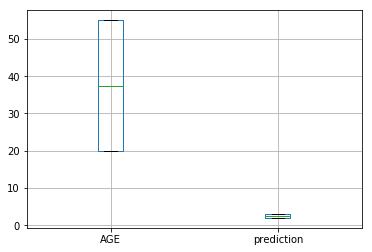

In [122]:
%matplotlib inline

pandas_df.boxplot()

### 5.2 Accessing data mart metrics
- performance
- quality
- fairness

Get all metrics.

In [19]:
client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': 'b61e1c6a-9f24-4011-8f63-bc9bc115de17',
    'asset_type': 'model',
    'created_at': '2018-09-20T08:12:15.741Z',
    'name': 'product-line-prediction',
    'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e30fe554-6e3e-4e0e-af06-90f93686f358/published_models/b61e1c6a-9f24-4011-8f63-bc9bc115de17'},
   'deployment': {'created_at': '2018-09-20T08:12:33.616Z',
    'deployment_id': 'a65b7a1c-3563-4748-a05d-9fbddb2f1c0c',
    'name': 'product line deployment',
    'url': 'https://us-south.ml.cloud.ibm.com/v3/wml_instances/e30fe554-6e3e-4e0e-af06-90f93686f358/deployments/a65b7a1c-3563-4748-a05d-9fbddb2f1c0c'},
   'metrics': [{'issues': 0,
     'metric_type': 'performance',
     'timestamp': '2018-09-20T08:47:28.102Z',
     'value': {'records': 96, 'response_time': 24.0}}],
   'subscription': {'subscription_id': 'b61e1c6a-9f24-4011-8f63-bc9bc115de17',
    'url': '/v1/data_marts/bc7b716c-9a22-4841-8221-fa28f565520d/subscriptions/b61e1c6a-

Get metric for particular deployment.

In [25]:
subscription.quality_monitoring.get_metrics(deployment_uid=subscription.get_deployment_uids()[0])

{'end': '2018-09-20T11:16:41.785491Z',
 'metrics': [{'asset_revision': 'eeaa586e-19c8-45c5-9ef5-1847d09f3f53',
   'process': 'learning iteration [157898df-75c3-4dcc-99f4-849137360949]',
   'timestamp': '2018-09-20T09:32:01.846Z',
   'value': {'metrics': [{'name': 'weightedTruePositiveRate', 'value': 0.25},
     {'name': 'accuracy', 'threshold': 0.8, 'value': 0.25},
     {'name': 'weightedFMeasure', 'value': 0.4000000000000001},
     {'name': 'weightedRecall', 'value': 0.25},
     {'name': 'weightedPrecision', 'value': 1.0}],
    'phase': 'monitoring',
    'quality': 0.25,
    'threshold': 0.8}},
  {'asset_revision': 'eeaa586e-19c8-45c5-9ef5-1847d09f3f53',
   'process': 'learning iteration [157898df-75c3-4dcc-99f4-849137360949]',
   'timestamp': '2018-09-20T09:32:24.800Z',
   'value': {'metrics': [{'name': 'weightedFMeasure',
      'value': 0.8232858700664133},
     {'name': 'accuracy', 'threshold': 0.8, 'value': 0.8242209805041195},
     {'name': 'weightedTruePositiveRate', 'value': 0.

<a id="setup"></a>
## 6. Visualization

Get the performance metrics as pandas dataframe.

In [104]:
performance_pdf = subscription.performance_monitoring.get_table_content()

Let's enrich our data by calculating additional metric: `throughput`

In [118]:
performance_pdf['throughput'] = performance_pdf.apply(lambda row: float((row.records/row.response_time)*1000) ,axis=1)

In [119]:
performance_pdf

,ts,response_time,records,binding_id,subscription_id,deployment_id,process,throughput
0,2018-09-20 12:03:17.870,90.0,180,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
1,2018-09-20 12:03:17.857,88.0,176,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
2,2018-09-20 12:03:17.844,89.0,178,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
3,2018-09-20 12:03:17.817,90.0,180,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
4,2018-09-20 11:28:54.529,101.0,198,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,1960.396040
5,2018-09-20 11:28:54.514,99.0,198,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
6,2018-09-20 11:28:54.461,99.0,198,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
7,2018-09-20 11:28:54.426,106.0,198,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,1867.924528
8,2018-09-20 08:47:23.838,24.0,48,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000
9,2018-09-20 08:47:23.811,25.0,50,e30fe554-6e3e-4e0e-af06-90f93686f358,e660f8ea-fb82-4f3e-9475-9817612abc2b,10e2f722-b2b2-4ece-89d4-b691c5ad0d04,None,2000.000000


Let's plot `throughput` over time.

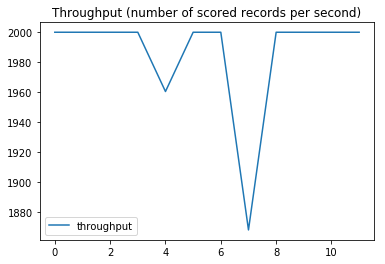

In [127]:
performance_pdf.plot.line(y='throughput', title='Throughput (number of scored records per second)');

---

### Authors
Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.